In [1]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
movies_ds = pd.read_csv('movies.csv')
ratings_ds=pd.read_csv('ratings.csv')

In [3]:
movies_ds

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings_ds

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
# Step 3: Pre-process the dataset
# Remove duplicates and missing values
movies_ds = movies_ds.drop_duplicates('movieId')
ratings_ds = ratings_ds.dropna()

# Merge movies and ratings based on movieId
merged_df = pd.merge(ratings_ds, movies_ds, on='movieId')

# Create a user-movie matrix
user_movie_matrix = merged_df.pivot_table(index='userId', columns='title', values='rating')
user_movie_matrix = user_movie_matrix.fillna(0)  # Fill missing values with 0

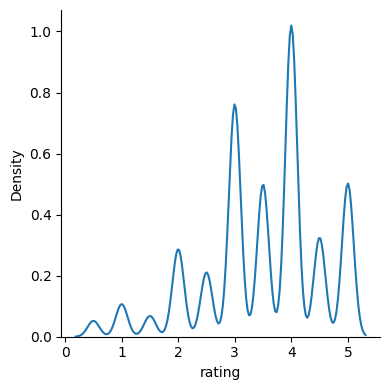

In [6]:
sns.displot(data=merged_df, x='rating', kind='kde', aspect=1, height=4)

In [7]:
# Step 4: Split the dataset into training and testing sets
train_data, test_data = train_test_split(user_movie_matrix, test_size=0.2, random_state=42)

In [8]:
# Step 5: Implement collaborative filtering algorithm (User-Based Collaborative Filtering)
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity matrix
user_similarity = cosine_similarity(train_data)
user_similarity_df = pd.DataFrame(user_similarity, index=train_data.index, columns=train_data.index)

C:\Users\vridd\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [9]:
# Step 6: Train the model
import numpy as np
def predict(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

user_prediction = predict(train_data.values, user_similarity)
user_prediction_df = pd.DataFrame(user_prediction, index=train_data.index, columns=train_data.columns)

In [10]:
# Step 7: Evaluate the model
def get_mae(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(actual, pred)

mae = get_mae(user_prediction, test_data.values)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3.081504446323629


In [17]:
# Step 8: Make movie recommendations for users
def recommend_movies(user_id, user_movie_matrix, user_prediction_df, num_recommendations=5):
    user_ratings = user_movie_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index

    rated_movies = user_prediction_df.loc[user_id]

    recommended_movies = rated_movies[unrated_movies].sort_values(ascending=False).head(num_recommendations)
    return recommended_movies.index

# Example: Recommend movies for user 1
user_id = 4
recommendations = recommend_movies(user_id, user_movie_matrix, user_prediction_df)
print(f"Top 5 recommended movies for User {user_id}:\n", recommendations)

Top 5 recommended movies for User 4:
 Index(['Shawshank Redemption, The (1994)', 'Forrest Gump (1994)',
       'Schindler's List (1993)', 'Godfather, The (1972)',
       'Usual Suspects, The (1995)'],
      dtype='object', name='title')
